## Problem 2

Consider the problem of water flowing through a heated square duct (see the figure below).

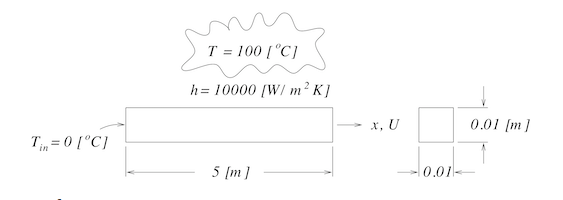

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s].  At the left boundary, set $\alpha_e = 1$ to ensure that the correct value of $T$ gets carried into the domain.  Then, carry out the following:

1. Solve the problem using UDS, CDS and QUICK and plot $T$ for all schemes along with $T_{exact}$ vs. $x$ with $\alpha_e$ = -1.0 at the right boundary.  Discuss the results.
2. Test the effect of $\alpha_e$ at the right boundary.  That is, set $\alpha_e$ = 1.0 at the right boundary, run the cases of (1) again and discuss the differences that occur.  What physical effect does setting $\alpha_e = \pm1.0$ at the right boundary have?  Which is realistic?
3. Reverse the flow direction and the boundary conditions re-run parts (1) and (2).  Show plots of $T$ vs. $x$.  Make sure you use appropriate values for $\alpha_e$ on the boundaries.  Your solutions should be the same as those from parts (1) and (2), except opposite.

Based on your results for this problem, make a general statement about how $\alpha_e$ should be set on the boundaries and why.

## Class definition

In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [2]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [4]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._cp*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [5]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


## Advection models defined with $\alpha_e = -1.0 $ at right boundary for positive flow and $\alpha_e = +1.0 $ at left boundary for reverse flow

In [6]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae[-1] = -1
            else:
                self._alphae[i] = -1
                self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [7]:
class CentralDifferenceModel:
    """Class defining a Central difference advection model with Deffered correction approach"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
 
    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae [-1] = -1
            else:
                self._alphae[i] = -1
                self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (self._phi[0:-1] + self._phi[1:])/2 # Using HOS
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] # For modification of boundary values
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face      
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
                
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)
 
        # Return the modified coefficient array
        return coeffs

In [8]:
import numpy as np

class QuickAdvectionModel1:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae[-1] = -1
            else:
                self._alphae[i] = -1
                self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1- self._alphae)/2*self._phi[1:]
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        for i in range(1,self._grid.ncv):
                if self._Uhe[i] >=0:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i] - self._grid.xP[i-1])*(self._grid.xP[i] - self._grid.xP[i+1])))*self._phi[i]  
                    T_3 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i])/((self._grid.xP[i+1] - self._grid.xP[i-1])*(self._grid.xP[i+1] - self._grid.xP[i])))*self._phi[i+1]
                    self._phie[i] = T_1 + T_2 + T_3
        
                else:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i] - self._grid.xP[i+1])*(self._grid.xP[i] - self._grid.xP[i+2])))*self._phi[i]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i+1] - self._grid.xP[i])*(self._grid.xP[i+1] - self._grid.xP[i+2])))*self._phi[i+1]  
                    T_3 =((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i+2] - self._grid.xP[i])*(self._grid.xP[i+2] - self._grid.xP[i+1])))*self._phi[i+2]                
                    self._phie[i] = T_1 + T_2 + T_3
   
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs


## Advection models defined with  $\alpha_e = +1.0 $ at right boundary for positive flow and $\alpha_e = -1.0 $ at left boundary for reverse flow

In [9]:
import numpy as np

class UpwindAdvectionModel2:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae[-1] = +1
            else:
                self._alphae[i] = -1
                self._alphae[0] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [10]:
class CentralDifferenceModel2:
    """Class defining a Central difference advection model with Deffered correction approach"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
 
    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae [-1] = +1
            else:
                self._alphae[i] = -1
                self._alphae[0] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (self._phi[0:-1] + self._phi[1:])/2 # Using HOS
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] 
        # For modification of boundary values
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face      
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
                
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)
 
        # Return the modified coefficient array
        return coeffs

In [11]:
import numpy as np

class QuickAdvectionModel2:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                self._alphae[-1] = +1 
            else:
                self._alphae[i] = -1
                self._alphae[0] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1- self._alphae)/2*self._phi[1:]
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        for i in range(1,self._grid.ncv):
                if self._Uhe[i] >=0:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i] - self._grid.xP[i-1])*(self._grid.xP[i] - self._grid.xP[i+1])))*self._phi[i]  
                    T_3 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i])/((self._grid.xP[i+1] - self._grid.xP[i-1])*(self._grid.xP[i+1] - self._grid.xP[i])))*self._phi[i+1]
                    self._phie[i] = T_1 + T_2 + T_3
        
                else:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i] - self._grid.xP[i+1])*(self._grid.xP[i] - self._grid.xP[i+2])))*self._phi[i]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i+1] - self._grid.xP[i])*(self._grid.xP[i+1] - self._grid.xP[i+2])))*self._phi[i+1]  
                    T_3 =((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i+2] - self._grid.xP[i])*(self._grid.xP[i+2] - self._grid.xP[i+1])))*self._phi[i+2]                
                    self._phie[i] = T_1 + T_2 + T_3
   
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs


# For flow in POSITIVE x-direction

## $\alpha_e$ = -1 at right boundary
## Solving with Upwind Differencing Scheme (UDS)

In [12]:
def UDS (ncv_def):    
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

        xp_uds = grid.xP
        T_uds = T

        return (T_uds,xp_uds)

In [13]:
T_uds_5, xp_uds_5 = UDS(5)
print(T_uds_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4.176776193577872e-11; Avg. Resid. = 2.567601342154177e-11
[273.         311.8972595  335.6645524  350.18701917 359.06064403
 364.48267161 364.48267161]


## Solving with Central Differencing Scheme (CDS)

In [14]:
def CDS(ncv_def):
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_cds = grid.xP
    T_cds = T
    return(T_cds,xp_cds)

In [15]:
T_cds_5, xp_cds_5 = CDS(5)
print(T_cds_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844071; Avg. Resid. = 2986.8356983376357
Iteration = 2; Max. Resid. = 1774.7247010436124; Avg. Resid. = 748.0769462738158
Iteration = 3; Max. Resid. = 527.2549491781333; Avg. Resid. = 276.86347268320776
Iteration = 4; Max. Resid. = 175.43990304169208; Avg. Resid. = 112.97284618843935
Iteration = 5; Max. Resid. = 96.91092775630692; Avg. Resid. = 45.31818323214797
Iteration = 6; Max. Resid. = 60.57660800012845; Avg. Resid. = 25.83299443311637
Iteration = 7; Max. Resid. = 36.82090381860214; Avg. Resid. = 18.0329072742388
Iteration = 8; Max. Resid. = 23.563683594804708; Avg. Resid. = 12.908598540914165
Iteration = 9; Max. Resid. = 17.11687236797519; Avg. Resid. = 8.648909035942808
Iteration = 10; Max. Resid. = 11.5481752642003; Avg. Resid. = 5.549985894656616
Iteration = 11; Max. Resid. = 7.433409824989526; Avg. Resid. = 3.4542026743296503
Iteration = 12; M

## Solving with QUICK Scheme

In [16]:
def QUICK(ncv_def):
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QuickAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_quick = grid.xP
    T_quick = T
    return(T_quick,xp_quick)

In [17]:
T_quick_5, xp_quick_5 = QUICK(5)
print(T_quick_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122691
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.4954791822471; Avg. Resid. = 237.79819167289983
Iteration = 4; Max. Resid. = 106.48614838813067; Avg. Resid. = 52.866851405055044
Iteration = 5; Max. Resid. = 24.59579347731343; Avg. Resid. = 9.838317390928966
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213395927
Iteration = 7; Max. Resid. = 3.162845284108209; Avg. Resid. = 1.6959148578516747
Iteration = 8; Max. Resid. = 0.886123045130923; Avg. Resid. = 0.5395651734583613
Iteration = 9; Max. Resid. = 0.4039343382269968; Avg. Resid. = 0.1615737352874343
Iteration = 10; Max. Resid. = 0.14249184284262195; Avg. Resid. = 0.06949494614654475
Iteration = 11; Max. Resid. = 0.05416584735336445; Avg. Resid. = 0.026312398216318773
Iterati

## Exact Solution for flow in positive direction

In [18]:
def ExactSoln(ncv_def):
    
    # Analytical solution
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)
    rho = 1000
    cp = 4189
    k = 0.590
    ho = 10000
    U0 = 1.5
    Po = 4*ly
    Af = ly*lz
    mdote = rho * U0 * Af
    Tinf = 373
    Tin =  273
    T_exact = Tinf - ((Tinf-Tin)*np.exp((-ho*Po*grid.xP)/(mdote*cp)))
    return(T_exact)

In [19]:
T_Exact = ExactSoln(5)
print(T_Exact)

[273.         300.2611055  334.51423808 352.63738821 362.22625049
 367.29966648 368.85364041]


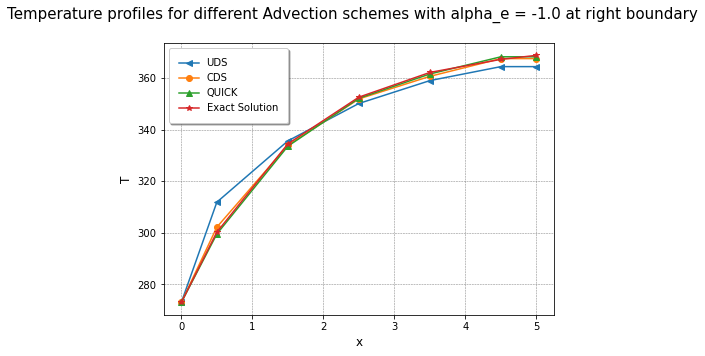

In [20]:
 """Plot for testing Accuracy of Numerical solution with Analytical solution """
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize =(7,5))

plt.plot(xp_uds_5, T_uds_5 , marker = "<", label = "UDS")
plt.plot(xp_cds_5, T_cds_5, marker = "o", label = "CDS")
plt.plot(xp_quick_5, T_quick_5 , marker = "^", label = "QUICK")
plt.plot(xp_uds_5, T_Exact , marker = "*", label = "Exact Solution")
plt.xlabel('x', fontsize = 12)
plt.ylabel('T', fontsize =12)
plt.suptitle('Temperature profiles for different Advection schemes with alpha_e = -1.0 at right boundary', fontsize=15)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Discussion


From the exact solution we have at the right most boundary, T = 368.85364 K. The UDS, CDS and QUICK schemes give 364.48267 K , 367.59622 K , 368.29993 K respectively. We know that the UDS scheme is only first order accurate and so it shows the largest deviation from the exact solution. The CDS and QUICK Scheme are second order advection schemes and so these give approximation closer to the exact solution.

## $\alpha_e$ = +1 at right boundary
## Solving with Upwind Differencing Scheme (UDS)

In [21]:
def UDS (ncv_def):    
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = UpwindAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

        xp_uds = grid.xP
        T_uds = T

        return (T_uds,xp_uds)

In [22]:
T_uds_5, xp_uds_5 = UDS(5)
print(T_uds_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 4.176776193577872e-11; Avg. Resid. = 2.567601342154177e-11
[273.         311.8972595  335.6645524  350.18701917 359.06064403
 364.48267161 364.48267161]


## Solving with Central Differencing Scheme (CDS)

In [23]:
def CDS(ncv_def):
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CentralDifferenceModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_cds = grid.xP
    T_cds = T
    return(T_cds,xp_cds)

In [24]:
T_cds_5, xp_cds_5 = CDS(5)
print(T_cds_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844071; Avg. Resid. = 2986.8356983376357
Iteration = 2; Max. Resid. = 1774.7247010436124; Avg. Resid. = 748.0769462738158
Iteration = 3; Max. Resid. = 527.2549491781333; Avg. Resid. = 276.86347268320776
Iteration = 4; Max. Resid. = 175.43990304169208; Avg. Resid. = 112.97284618843935
Iteration = 5; Max. Resid. = 96.91092775630692; Avg. Resid. = 45.31818323214797
Iteration = 6; Max. Resid. = 60.57660800012845; Avg. Resid. = 25.83299443311637
Iteration = 7; Max. Resid. = 36.82090381860214; Avg. Resid. = 18.0329072742388
Iteration = 8; Max. Resid. = 23.563683594804708; Avg. Resid. = 12.908598540914165
Iteration = 9; Max. Resid. = 17.11687236797519; Avg. Resid. = 8.648909035942808
Iteration = 10; Max. Resid. = 11.5481752642003; Avg. Resid. = 5.549985894656616
Iteration = 11; Max. Resid. = 7.433409824989526; Avg. Resid. = 3.4542026743296503
Iteration = 12; M

## Solving with QUICK Scheme

In [25]:
def QUICK(ncv_def):
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1.5

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QuickAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_quick = grid.xP
    T_quick = T
    return(T_quick,xp_quick)

In [26]:
T_quick_5, xp_quick_5 = QUICK(5)
print(T_quick_5)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122691
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.4954791822471; Avg. Resid. = 237.79819167289983
Iteration = 4; Max. Resid. = 106.48614838813067; Avg. Resid. = 52.866851405055044
Iteration = 5; Max. Resid. = 24.59579347731343; Avg. Resid. = 9.838317390928966
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213395927
Iteration = 7; Max. Resid. = 3.162845284108209; Avg. Resid. = 1.6959148578516747
Iteration = 8; Max. Resid. = 0.886123045130923; Avg. Resid. = 0.5395651734583613
Iteration = 9; Max. Resid. = 0.4039343382269968; Avg. Resid. = 0.1615737352874343
Iteration = 10; Max. Resid. = 0.14249184284262195; Avg. Resid. = 0.06949494614654475
Iteration = 11; Max. Resid. = 0.05416584735336445; Avg. Resid. = 0.026312398216318773
Iterati

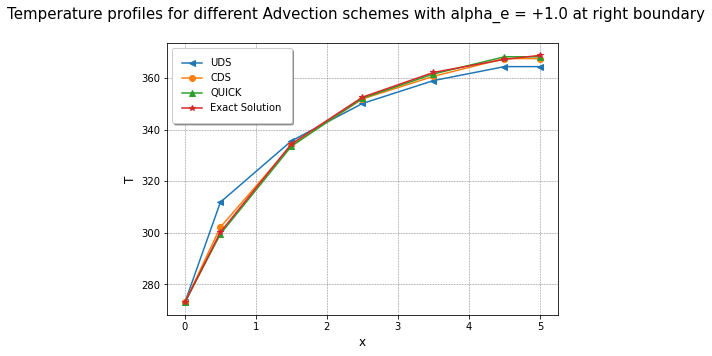

In [27]:
 """Plot for testing Accuracy of Numerical solution with Analytical solution """
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize =(7,5))

plt.plot(xp_uds_5, T_uds_5 , marker = "<", label = "UDS")
plt.plot(xp_cds_5, T_cds_5, marker = "o", label = "CDS")
plt.plot(xp_quick_5, T_quick_5 , marker = "^", label = "QUICK")
plt.plot(xp_uds_5, T_Exact , marker = "*", label = "Exact Solution")
plt.xlabel('x', fontsize = 12)
plt.ylabel('T', fontsize =12)
plt.suptitle('Temperature profiles for different Advection schemes with alpha_e = +1.0 at right boundary', fontsize=15)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Discussion

The right boundary condition is Neumann BC with 0 gradient, which means the temperature profile is fully developed i.e. the temperature at the righmost boundary is nothing but the cell center value of the boundary adjacent cell. Since the right boundary value and the adjacent cell value are equal, then $\alpha_e$ does not matter anymore.  Thus, we can conclude that it is expected that the results from none of the schemes change when $\alpha_e$ is changed at the right boundary (+1 or -1) i.e. no physical effect of setting $\alpha_e = \pm1.0$  when the boundary condition is Neumann , because Neumann BC means temperature profile is fully developed.
However, for flow in the positive direction, it is more realistic to set $\alpha_e = -1$ at the right boundary because that ascertains that the the east face boundary value is equal to the specified boundary temperature. 
Furthermore, the UDS scheme converges in one iteration since the linearization is exact, but for CDS and QUICK, it takes more than 1 iteration since the linearization is inexact. 


# For Reverse flow (flow in NEGATIVE x-direction)

## $\alpha_e$ = +1.0 at left boundary
## Solving with Upwind Differencing Scheme (UDS)


In [28]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_reverse1 = grid.xP
T_uds_reverse1 = T
print(T_uds_reverse1)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7.860663131600639e-11; Avg. Resid. = 4.8676794519834655e-11
[364.48267161 364.48267161 359.06064403 350.18701917 335.6645524
 311.8972595  273.        ]


### Solving with Central Differencing Scheme (CDS)

In [29]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 50
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_reverse1 = grid.xP
T_cds_reverse1 = T
print(T_cds_reverse1)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844071; Avg. Resid. = 2986.835698337641
Iteration = 2; Max. Resid. = 1774.7247010436706; Avg. Resid. = 748.0769462738342
Iteration = 3; Max. Resid. = 527.2549491781115; Avg. Resid. = 276.86347268320344
Iteration = 4; Max. Resid. = 175.43990304164114; Avg. Resid. = 112.97284618842335
Iteration = 5; Max. Resid. = 96.91092775630692; Avg. Resid. = 45.31818323216544
Iteration = 6; Max. Resid. = 60.57660800012845; Avg. Resid. = 25.83299443311637
Iteration = 7; Max. Resid. = 36.82090381860214; Avg. Resid. = 18.0329072742388
Iteration = 8; Max. Resid. = 23.563683594804708; Avg. Resid. = 12.908598540914165
Iteration = 9; Max. Resid. = 17.11687236797519; Avg. Resid. = 8.648909035942808
Iteration = 10; Max. Resid. = 11.5481752642003; Avg. Resid. = 5.549985894656616
Iteration = 11; Max. Resid. = 7.433409824989526; Avg. Resid. = 3.4542026743296512
Iteration = 12; Ma

### Solving with QUICK Advection Scheme 

In [30]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = QuickAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_reverse1 = grid.xP
T_quick_reverse1 = T
print(T_quick_reverse1)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122696
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.495479182218; Avg. Resid. = 237.79819167288824
Iteration = 4; Max. Resid. = 106.48614838815432; Avg. Resid. = 52.86685140505976
Iteration = 5; Max. Resid. = 24.595793477284325; Avg. Resid. = 9.838317390917323
Iteration = 6; Max. Resid. = 8.044481678185548; Avg. Resid. = 4.579300213419209
Iteration = 7; Max. Resid. = 3.162845284057277; Avg. Resid. = 1.6959148577961956
Iteration = 8; Max. Resid. = 0.8861230451245565; Avg. Resid. = 0.5395651734616356
Iteration = 9; Max. Resid. = 0.403934338197893; Avg. Resid. = 0.16157373528034027
Iteration = 10; Max. Resid. = 0.1424918427844143; Avg. Resid. = 0.06949494612326171
Iteration = 11; Max. Resid. = 0.054165847435218975; Avg. Resid. = 0.026312398249060582
Iterat

## Exact Solution for flow in negative direction

In [31]:
def ExactSolnRev(ncv_def):
    import numpy as np
    # Analytical solution
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)
    rho = 1000
    cp = 4189
    k = 0.590
    ho = 10000
    U0 = 1.5
    Po = 4*ly
    Af = ly*lz
    mdote = rho * U0 * Af
    Tinf = 373
    Tin =  273
    T_exact =  Tinf - ((Tinf-Tin)*np.exp((-ho*Po*grid.xP)/(mdote*cp)))
    return(np.flip(T_exact))

In [32]:
T_exact_reverse = ExactSolnRev(5)
print(T_exact_reverse)

[368.85364041 367.29966648 362.22625049 352.63738821 334.51423808
 300.2611055  273.        ]


### Comparison of results with case of Positive flow ($\alpha_e =-1.0 $ at right boundary)

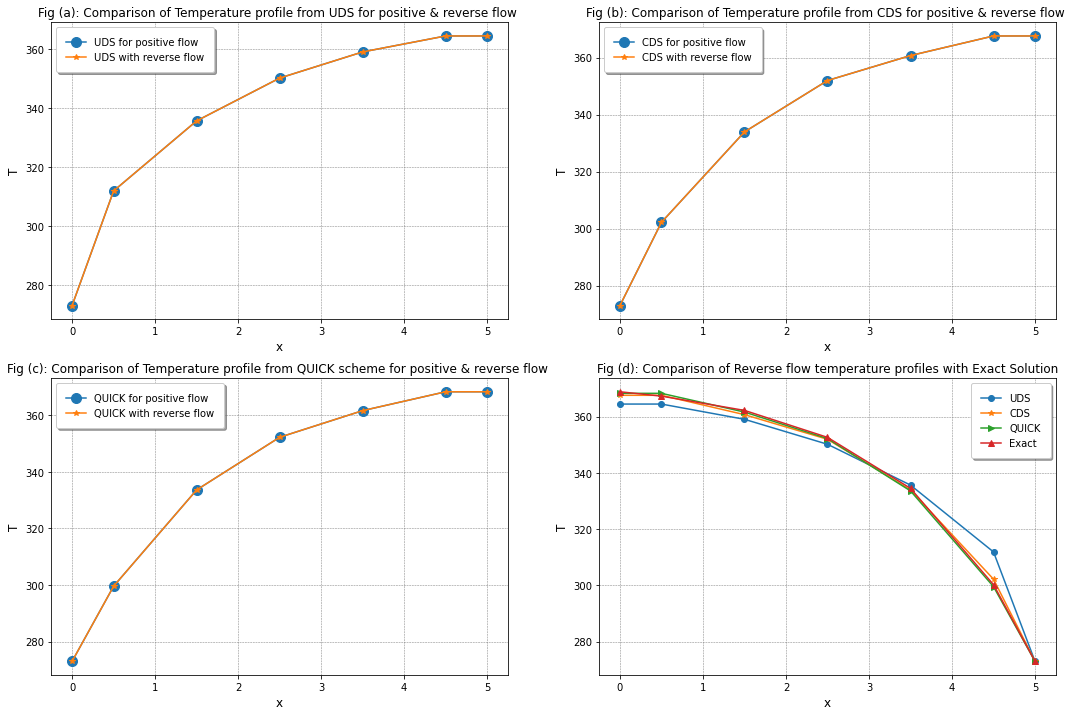

In [33]:
""" Plot for Comparison of UDS scheme for flow in positive and negative direction """
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(18,12))
axes1 = fig.add_subplot(2,2,1)
axes2 = fig.add_subplot(2,2,2)
axes3 = fig.add_subplot(2,2,3)
axes4 = fig.add_subplot(2,2,4)

axes1.plot(xp_uds_5, T_uds_5, marker = "o",markersize=10, label = "UDS for positive flow")
axes1.plot(np.flip(xp_uds_reverse1),T_uds_reverse1 , marker = "*", label = "UDS with reverse flow")
axes1.set_xlabel('x',fontsize = 12)
axes1.set_ylabel('T',fontsize = 12)
axes1.set_title('Fig (a): Comparison of Temperature profile from UDS for positive & reverse flow ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(xp_cds_5, T_cds_5, marker = "o",markersize=10, label = "CDS for positive flow")
axes2.plot(np.flip(xp_cds_reverse1),T_cds_reverse1 , marker = "*", label = "CDS with reverse flow")
axes2.set_xlabel('x',fontsize = 12)
axes2.set_ylabel('T',fontsize = 12)
axes2.set_title('Fig (b): Comparison of Temperature profile from CDS for positive & reverse flow ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(xp_quick_5, T_quick_5, marker = "o",markersize=10, label = "QUICK for positive flow")
axes3.plot(np.flip(xp_quick_reverse1),T_quick_reverse1 , marker = "*", label = "QUICK with reverse flow")
axes3.set_xlabel('x',fontsize = 12)
axes3.set_ylabel('T',fontsize = 12)
axes3.set_title('Fig (c): Comparison of Temperature profile from QUICK scheme for positive & reverse flow ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(xp_uds_reverse1,T_uds_reverse1, marker = "o", label = "UDS")
axes4.plot(xp_cds_reverse1,T_cds_reverse1, marker = "*", label = "CDS")
axes4.plot(xp_quick_reverse1,T_quick_reverse1, marker = ">",label = "QUICK")
axes4.plot(xp_uds_5,T_exact_reverse , marker = "^", label = "Exact")
axes4.set_xlabel('x',fontsize = 12)
axes4.set_ylabel('T',fontsize = 12)
axes4.set_title('Fig (d): Comparison of Reverse flow temperature profiles with Exact Solution',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

We reversed the flow direction and the boundary conditions and ran all three schemes with $\alpha_e = +1$ at the left boundary and plotted the flipped temperature profiles and saw that they turned out same for those of $\alpha_e = -1$ at the right boundary for positive flow for UDS , CDS and QUICK [Fig (a),(b) and (c)].In [Fig (d)], we plotted the results for reverse flow with  $\alpha_e = +1$ at the left boundary, with the fliped exact solution for positive flow and saw that, the UDS scheme like before gives a temperature of 364 K at the left boundary where we have set Neumann BC with 0 temperature gradient, whereas, CDS and QUICK give close to 368 K (i.e. exact solution). This happens because UDS is first order accurate,whereas CDS & QUICK scheme are  2nd order advection schemes.

## $\alpha_e$ = -1.0 at left boundary
## Solving with Upwind Differencing Scheme (UDS)


In [34]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_uds_reverse2 = grid.xP
T_uds_reverse2 = T
print(T_uds_reverse2)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7.860663131600639e-11; Avg. Resid. = 4.8676794519834655e-11
[364.48267161 364.48267161 359.06064403 350.18701917 335.6645524
 311.8972595  273.        ]


### Solving with Central Differencing Scheme (CDS)

In [35]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 50
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = CentralDifferenceModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_cds_reverse2 = grid.xP
T_cds_reverse2 = T
print(T_cds_reverse2)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844071; Avg. Resid. = 2986.835698337641
Iteration = 2; Max. Resid. = 1774.7247010436706; Avg. Resid. = 748.0769462738342
Iteration = 3; Max. Resid. = 527.2549491781115; Avg. Resid. = 276.86347268320344
Iteration = 4; Max. Resid. = 175.43990304164114; Avg. Resid. = 112.97284618842335
Iteration = 5; Max. Resid. = 96.91092775630692; Avg. Resid. = 45.31818323216544
Iteration = 6; Max. Resid. = 60.57660800012845; Avg. Resid. = 25.83299443311637
Iteration = 7; Max. Resid. = 36.82090381860214; Avg. Resid. = 18.0329072742388
Iteration = 8; Max. Resid. = 23.563683594804708; Avg. Resid. = 12.908598540914165
Iteration = 9; Max. Resid. = 17.11687236797519; Avg. Resid. = 8.648909035942808
Iteration = 10; Max. Resid. = 11.5481752642003; Avg. Resid. = 5.549985894656616
Iteration = 11; Max. Resid. = 7.433409824989526; Avg. Resid. = 3.4542026743296512
Iteration = 12; Ma

### Solving with QUICK Advection Scheme 

In [36]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = QuickAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
            
xp_quick_reverse2 = grid.xP
T_quick_reverse2 = T
print(T_quick_reverse2)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050030671; Avg. Resid. = 5250.036200122696
Iteration = 2; Max. Resid. = 1513.5391187287648; Avg. Resid. = 605.4156474915019
Iteration = 3; Max. Resid. = 594.495479182218; Avg. Resid. = 237.79819167288824
Iteration = 4; Max. Resid. = 106.48614838815432; Avg. Resid. = 52.86685140505976
Iteration = 5; Max. Resid. = 24.595793477284325; Avg. Resid. = 9.838317390917323
Iteration = 6; Max. Resid. = 8.044481678185548; Avg. Resid. = 4.579300213419209
Iteration = 7; Max. Resid. = 3.162845284057277; Avg. Resid. = 1.6959148577961956
Iteration = 8; Max. Resid. = 0.8861230451245565; Avg. Resid. = 0.5395651734616356
Iteration = 9; Max. Resid. = 0.403934338197893; Avg. Resid. = 0.16157373528034027
Iteration = 10; Max. Resid. = 0.1424918427844143; Avg. Resid. = 0.06949494612326171
Iteration = 11; Max. Resid. = 0.054165847435218975; Avg. Resid. = 0.026312398249060582
Iterat

### Comparison of results with case of Positive flow ($\alpha_e =+1.0 $ at right boundary)

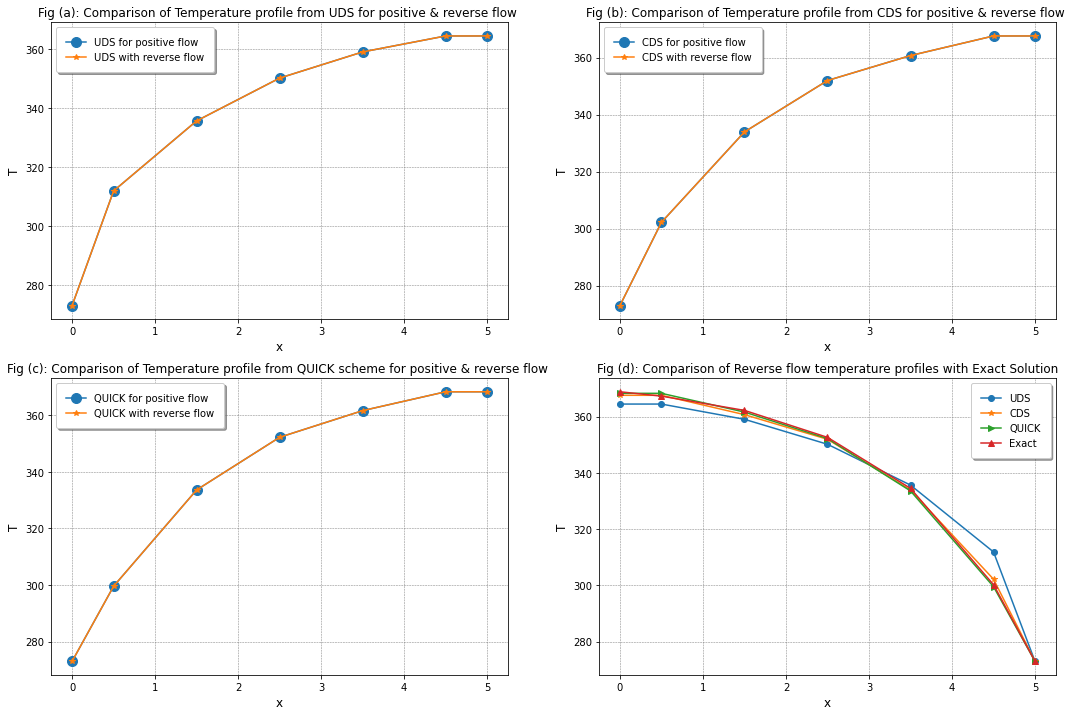

In [37]:
""" Plot for Comparison of UDS scheme for flow in positive and negative direction """
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(18,12))
axes1 = fig.add_subplot(2,2,1)
axes2 = fig.add_subplot(2,2,2)
axes3 = fig.add_subplot(2,2,3)
axes4 = fig.add_subplot(2,2,4)

axes1.plot(xp_uds_5, T_uds_5, marker = "o",markersize=10, label = "UDS for positive flow")
axes1.plot(np.flip(xp_uds_reverse2),T_uds_reverse2 , marker = "*", label = "UDS with reverse flow")
axes1.set_xlabel('x',fontsize = 12)
axes1.set_ylabel('T',fontsize = 12)
axes1.set_title('Fig (a): Comparison of Temperature profile from UDS for positive & reverse flow ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(xp_cds_5, T_cds_5, marker = "o",markersize=10, label = "CDS for positive flow")
axes2.plot(np.flip(xp_cds_reverse2),T_cds_reverse2 , marker = "*", label = "CDS with reverse flow")
axes2.set_xlabel('x',fontsize = 12)
axes2.set_ylabel('T',fontsize = 12)
axes2.set_title('Fig (b): Comparison of Temperature profile from CDS for positive & reverse flow ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(xp_quick_5, T_quick_5, marker = "o",markersize=10, label = "QUICK for positive flow")
axes3.plot(np.flip(xp_quick_reverse2),T_quick_reverse2 , marker = "*", label = "QUICK with reverse flow")
axes3.set_xlabel('x',fontsize = 12)
axes3.set_ylabel('T',fontsize = 12)
axes3.set_title('Fig (c): Comparison of Temperature profile from QUICK scheme for positive & reverse flow ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(xp_uds_reverse2,T_uds_reverse2, marker = "o", label = "UDS")
axes4.plot(xp_cds_reverse2,T_cds_reverse2, marker = "*", label = "CDS")
axes4.plot(xp_quick_reverse2,T_quick_reverse2, marker = ">",label = "QUICK")
axes4.plot(xp_uds_5,T_exact_reverse , marker = "^", label = "Exact")
axes4.set_xlabel('x',fontsize = 12)
axes4.set_ylabel('T',fontsize = 12)
axes4.set_title('Fig (d): Comparison of Reverse flow temperature profiles with Exact Solution',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

We reversed the flow direction and the boundary conditions and ran all three schemes with $\alpha_e = -1$ at the left boundary and plotted the flipped temperature profiles and saw that they turbed out same for those of $\alpha_e = +1$ at the right boundary for positive flow for UDS , CDS and QUICK [Fig (a),(b) and (c)].In [Fig (d)], we plotted the results for reverse flow with  $\alpha_e = -1$ at the left boundary, with the fliped exact solution for positive flow and saw that, the UDS scheme like before gives a temperature of 364 K at the left boundary where we have set Neumann BC with 0 temperature gradient, whereas, CDS and QUICK give close to 368 K (i.e. exact solution)



## General statement about setting value of $\alpha_e$ at the boundaries

When implementing higher order schemes using the deferred correction approach, we use the higher order scheme at the interior faces only. At the boundary, we take either the upstream or downstream cell value and that is set by $\alpha_e$. 

The value of $\alpha_e$ at the inlet boundary should always be set constant i.e. for flow in positive x-direction, $\alpha_e$ at left boundary (inlet) should always be +1 and for flow in the negative x-direction, $\alpha_e$ at the right boundary (inlet) should always be -1 to ensure that the correct value is being advected into the domain.

Elsewhere in the domain,we can set $\alpha_e$ = +1 or -1 depending on whether we want to calculate the value of the scalar variable at a face from an upstream cell or a downstream cell.  

And at the outlet boundary, for flow in the positive x-direction, if we set $\alpha_e = -1$, it means that the value of the scalar that is advected out of the outlet boundary is equal to boundary value we set at the outlet, and if we set $\alpha_e = +1 $ it means that the value of the scalar advected out of the outlet boundary is equal to the outlet boundary adjacent cell centered value.